In [1]:
import os
from os import path
import random
import cv2
from tqdm import tqdm
import pickle

import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot
from matplotlib.image import imread
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader


# https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/

In [2]:
FOLDER = '/Pictures/'
IMG_SIZE = 215
CURRENT_DIR = path.abspath(path.curdir)
BATCH_SIZE = 128
NUM_EPOCHS = 50
LR = 0.001


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [14]:
files = os.listdir(CURRENT_DIR + FOLDER)
images = []
names = []

for file in tqdm(files):
    
    name = file.split('.')[0]
    names.append(name)

    image = cv2.imread(os.path.join(CURRENT_DIR + FOLDER,file))
    images.append(image)

train = pd.DataFrame({'image':images,'name':names}).sample(frac=1).reset_index(drop=True)

100%|██████████| 890/890 [00:00<00:00, 1025.72it/s]


Text(0.5, 0, 'Pupitar')

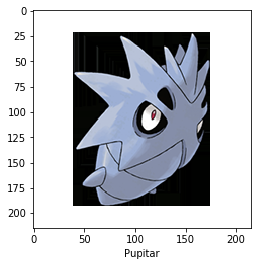

In [19]:
sample = train.sample(n=1)
pyplot.imshow(cv2.cvtColor(sample['image'].values[0],cv2.COLOR_BGR2RGB))
label = sample['name'].values[0]
pyplot.xlabel(label)